# Learning with ensembles

The goal of **ensemble methods** is to combine different classfiers into a meta classfier that has better generalization performance than each individual classifier alone.

Using the training dataset, we start by training $m$ different classfiers $(C_1,\dots,C_m)$. 
To predict a class label via simple majority or plurality voting, we can combine the predicted class labels of each individual classifier, $C_j$, and select the class label $\hat{y}$, that received the most votes:
$$
\hat{y}=\mathrm{mode}\{C_1(x),\dots,C_m(x)\}
$$


To illustrate that ensemble methods works better than individual classfiers alone. Assume that all $n$ independent base classifiers for a binary classification task have an euqal error rate $\epsilon$ (un-correlated). Then the error probability distribution of an ensemble of base classifiers is
$$
P(y\geq k)=\sum_{k=1}^n\binom{n}{k}\epsilon^k(1-\epsilon)^{n-k}=\epsilon_{\text{ensemble}}
$$
when $\epsilon=0.25$, $n=11$, we have
$$
P(y\geq k)=\sum_{k=6}^{11}\binom{11}{6}0.25^k(1-0.25)^{11-k}=0.034
$$
as the result shows, the error rate of the ensemble(0.034) is much lower than the error rate of each individual classfier(0.25).

In [5]:
from scipy.special import comb
import math

def ensemble_error(n_classfier, error):
    k_start = int(math.ceil(n_classfier / 2.))
    probs = [comb(n_classfier, k) * error**k * (1-error)**(n_classfier-k)
            for k in range(k_start, n_classfier+1)]
    return sum(probs)

ensemble_error(n_classfier=11, error=0.25)

0.03432750701904297

Now we can compute the ensemble error rate for a range of different base errors from 0.0 to 1.0 to visualize the relationship between ensemble and base errors in a line graph:

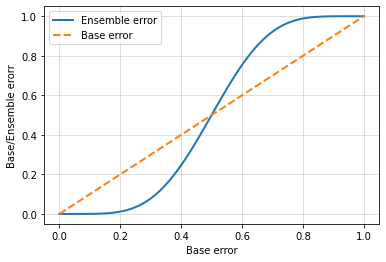

In [6]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classfier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble erorr')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


As the result shows, the error probability of an ensemble is always better than the error of an individual base classifier, as long as the base classifiers perform better than random guessing ($\epsilon<0.5$)

# Combining classifiers via majority vote



## Implementing a simple majority vote classifier
Our goal is to build a stronger meta-classifier that balances out the individual classifiers weaknesses on a particular dataset.

In more precise mathematical terms,
$$
\hat{y}=\arg\max_{i}\sum_{i=1}^mw_j\chi_A(C_j(x)=i)
$$
where $w_j$ is a weight associated with a base classifier, $C_j$, $\hat{y}$ is the predicted class label of the ensemble, $A$ is the set of unique class labels, $\chi_A$ is the characteristic function or indicator function.

For equal weights, we cam simplify this equation and write it as follows:
$$
\hat{y}=\mathrm{mode}\{C_1(x),\dots,C_m(x)\}
$$

To translate the concept of weigthed majority vote, we use the `argmax` and `bincount` functions

In [7]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

The modified version of the majority vote for predicting class labels from probabilities can be written as follows:
$$
\hat{y}=\arg\max_{i}\sum_{i=1}^mw_jp_{ij}
$$
where $p_{ij}$ is the predicted probability of the $j$-th classifier for class label $i$.


In [8]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [9]:
np.argmax(p)

0

Now we implement the `MajorityVoteClassifier` in Python

In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators

import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier
    classifiers: array_like, shape=[n_classifiers]
        Different classifiers for the ensemble
        
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on the argmax
        of the class labels.
        Else if 'probability', the argmax of the sum of probabilities is used to
        predict the class labels (recommanded for calibrated classifiers).
    
    weights: array-like, shape=[n_classifiers]
        Optional, default:None
        If a list of 'int' or 'float' values are provided, the classifiers
        are weighted by importance; Users uniform weights if 'weights=None'
    
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value 
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """Fit classifiers
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_examples, n_features]
            Matrix of training examples
        
        y: array-like, shape = [n_examples]
            vector of target class labels
        
        Returns
        ----------
        self: object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability'" 
                             "or 'classlabel';got (vote=%r)" 
                             % self.vote)
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights"
                            "must be equal; got %d weights,"
                            "%d classfiers"
                            % (len(self.weights), len(self.classifiers)))
        
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self 
    
    def predict(self, X):
        """Predict class labels for X
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_examples, n_features]
            Matrix of training examples
            
        Return 
        ----------
        maj_vote: array-like, shape = [n_examples]
        Predicted class labels.
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(
                                            np.bincount(x,
                                            weights=self.weights)),
                                            axis=1, arr=predictions)

        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        
        return maj_vote
        
    def predict_proba(self, X):
        """Predict class probabilities for X

        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features

        Return 
        ----------
        avg_proba: array-like, shape = [n_examples, n_classes]
            weighted averages probability for each class per example
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)

        return avg_proba
        
    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value

            return out
            

## Using the majority voting principle to make predictions
We will use Iris dataset from sklearn's `dataset` module, and we only choose two features, `sepal width` and `petal length` to make the classification task more chanllenging for illustration purposes. Moreover, we will only classifiy flower examples from the `Iris-versicolor` and `Iris-virginica` classes.

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Split the Iris examples into 50 percent training and 50 precent test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.5,
                                                   random_state=1,
                                                   stratify=y)

We will now train three different classifiers:
- Logistic regression classifier
- Decision tree classifier
- k-nearest neighbors classifier

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                         C=0.001,
                         solver='lbfgs',
                         random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train, y=y_train,
                            cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


**Notes**: We train the logistic regression and k-nearest neighbors classifier as part of pipeline, as both the logistic regression and k-nearest neighbors algorithms are not scale-invariant, in contrast to decision tress.

Now we combine the individual classifiers for majority rule voting in our `MajorityVoteClassifier`

In [14]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train, y=y_train,
                            cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## Evaluating and tuning ensemble classifier
We are going to compute the ROC curves from the test dataset to check that `MajorityVoteClassifier` generalizes well with unseen data.

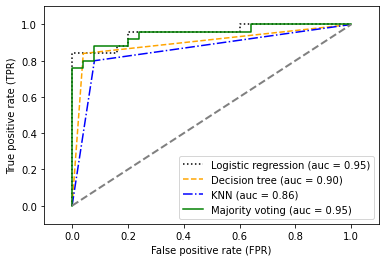

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in \
    zip(all_clf, clf_labels, colors, linestyles):
    # assume the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, 
             label='%s (auc = %.2f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

As the figure shows, the ensemble classifier performs well on the test dataset(ROC AUC=0.95). However, the logistic regression classifier performs similarly well on the same dataset, which is probably due to the high variance given the small size of the dataset.

Since we only selected two features for the classification examples, we now see what the decision region of the ensemble classifer actually looks like.

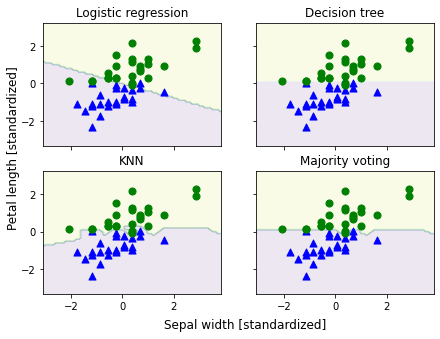

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col', sharey='row',
                       figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.1)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', 
         ha='center', va='center', fontsize=12, rotation=90)
plt.show()

We now call the `get_params()` method to get a basic idea of how we can acess the individual parameters insider a `GridSearchCV` object

In [17]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

We now tune the inverse regularization parameter, $C$ of the logistic regression classifier and the decision tree depth via a grid search for demonstration purposes

In [18]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

We can print the different hyper-parameter value combinations and the average ROC AUC scores computed via 10-fold cross-validation as follows:

In [19]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.4f +/- %0.2f %r" 
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

0.9833 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.9833 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.9667 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.9833 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.9833 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.9667 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [20]:
print('Best oarameters: %s' % grid.best_params_)

Best oarameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [21]:
print('Accuracy: %.3f' % grid.best_score_)

Accuracy: 0.983


# Bagging-building an ensemble of classifiers from bootstrap samples

## Applying bagging to classify examples in the Wine dataset

In [22]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of ash',
                  'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines',
                  'Proline']
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

Encode the class labels into binary format and split the dataset into 80 percent training and 20 percent test datasets, respectively

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

We now use an unpruned decision tree as the base classifier and create an ensemble of 500 decision trees fit on different bootstrap samples of the training samples

In [28]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

Compare the performance of the bagging classifier to the performance of a single unpruned decision tree:

In [29]:
from sklearn.metrics import accuracy_score
tree  = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


The unpruned decision tree predicts all the class labels of the training examples correctly; however, the substantially lower test accuracy indicates high variance (overfitting) of the model

In [30]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.917


We can see that the bagging classifier has a slightly better generalization performance, as estimated on the test dataset. Next, we compare the decision regions between the decision tree and the bagging classifier:

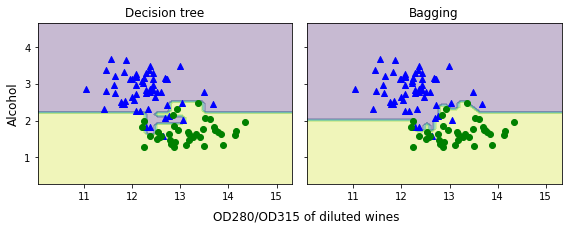

In [34]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col', 
                       sharey='row',
                       figsize=(8, 3))

for idx, clf, tt in zip([0, 1], 
                        [tree, bag], 
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
        s='OD280/OD315 of diluted wines',
        ha='center',
        va='center',
        fontsize=12,
        transform=axarr[1].transAxes)
plt.show()
    

As we can see, the piecewise linear decision boundary of the three-node deep decisio tree looks smoother in the bagging ensemble

# Leveraging weak learners via adaptive boosting
In boosting, the ensemble consists of very simple base classifiers, also often referred to as **weak learners**, which often only have a slight performance advantage over random guessing- a typical example of a weak learner is a decision tree stump.

## How boosting works
The original boosting procedure can be summarized in the following four key steps:
1. Draw a random subset (sample) of training examples, $d_1$, without replacement from the training dataset, $D$, to train a weak learning, $C_1$.
2. Draw a second ramdom training subset, $d_2$, without replacement from the training dataset and add 50 percent of the examples of the examples that were previously misclassified to train a weak learner $C_2$.
3. Find the training examples, $d_3$, in the training dataset, $D$, which $C_1$ and $C_2$ disagree upon, to train a third weak learner, $C_3$.
4. Combine the weak learners, $C_1,C_2$ and $C_3$ via majority voting.

The AdaBoost algorithm
1. Set the weight vector, $w$, to uniform weights, where $\sum_i w_i=1$.
2. For $j$ in $m$ boosting rounds, do the following:
    1. Train a weighted weak learner: $C_j=train(X,y,w)$.
    2. Predict class labels: $\hat{y}=predict(C_j,X)$.
    3. Compute weighted error rate: $\epsilon=w\cdot(\hat{y}\neq y)$
    4. Compute coefficient: $\alpha_j=0.5\log\frac{1-\epsilon}{\epsilon}$
    5. Update weights $w=w\times \exp(-\alpha_j\times\hat{y}\times y)$.
    6. Normalize weights to sum to $1$: $w=w/\sum_iw_i$.
3. Compute the final prediction: 
$$
\hat{y}=\left(\sum_{j=1}^m(\alpha_j\times predict(C_j,X))>0\right)
$$

## Applying AdaBoost using scikit-learn

In [35]:
from sklearn.ensemble import AdaBoostClassifier
tree =  DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


The decision tree stump seems to undefit the training data in contrast to the unpruned decision tree that we saw in the previous section

In [36]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree train/test accuracies 1.000/0.917


The AdaBoost model predicts all class labels of the training dataset correctly and also shows a slightly improved test dataset performance compared to the decision tree stump. However, we introduced additional variance by our attempt to reduce the model bias--a greater gap between training and test performance

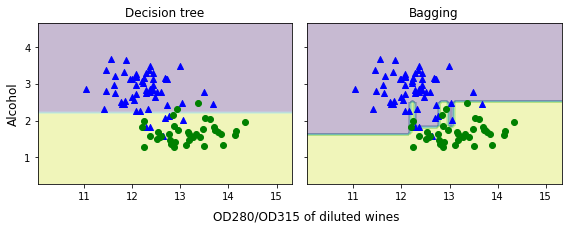

In [37]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col', 
                       sharey='row',
                       figsize=(8, 3))

for idx, clf, tt in zip([0, 1], 
                        [tree, ada], 
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
        s='OD280/OD315 of diluted wines',
        ha='center',
        va='center',
        fontsize=12,
        transform=axarr[1].transAxes)
plt.show()

As conclusion remarks about ensemble techniques, it is worth noting that ensemble learning increases the computational complexity compared to individual classifiers. In practice, we need to think about whether we want to pay the price of increased computational cost for an often relatively modest improvement in predictive performance.